# Age Prediction

In this puzzle, we have to predict the age from the given human faces.

## Setup AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [3]:
# !pip install aicrowd-cli
%load_ext aicrowd.magic
%aicrowd login

The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic
Please login here: https://api.aicrowd.com/auth/F8hJxZFU3J_pbchwPRzeJi3NUYVh945txyLjh4NLam8
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset

We will create a folder name data and download the files there.


In [5]:
!mkdir data
%aicrowd ds dl -c age-prediction -o data

train.csv: 100%|██████████| 48.3k/48.3k [00:00<00:00, 236kB/s]
test.csv: 100%|██████████| 36.0k/36.0k [00:00<00:00, 228kB/s]
sample_submission.csv: 100%|██████████| 36.0k/36.0k [00:00<00:00, 229kB/s]
train.zip:   0%|          | 0.00/236M [00:00<?, ?B/s]


val.csv: 100%|██████████| 24.2k/24.2k [00:00<00:00, 439kB/s]
train.zip:   1%|▏         | 3.15M/236M [00:02<02:18, 1.68MB/s]
train.zip:   2%|▏         | 5.24M/236M [00:02<01:47, 2.14MB/s]

train.zip:   3%|▎         | 7.34M/236M [00:03<01:40, 2.28MB/s]


train.zip:   4%|▍         | 9.44M/236M [00:04<01:34, 2.39MB/s]
train.zip:   5%|▌         | 12.6M/236M [00:05<01:28, 2.53MB/s]
train.zip:   6%|▌         | 13.6M/236M [00:05<01:17, 2.87MB/s]
train.zip:   6%|▌         | 14.7M/236M [00:06<01:29, 2.48MB/s]
train.zip:   7%|▋         | 15.7M/236M [00:06<01:18, 2.79MB/s]
train.zip:   7%|▋         | 16.8M/236M [00:06<01:10, 3.09MB/s]
train.zip:   8%|▊         | 18.9M/236M [00:07<01:23, 2.61MB/s]

train.zip:   9%|▉         | 21.0M/236M [00:08<01:

In [6]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Dataset

In [8]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/sample_submission.csv")

In [24]:
display(train_df.head(5))

print(f"Train: {train_df.shape[0]}, Val: {val_df.shape[0]}, Test: {test_df.shape[0]}")

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10


Train: 4000, Val: 2000, Test: 3000


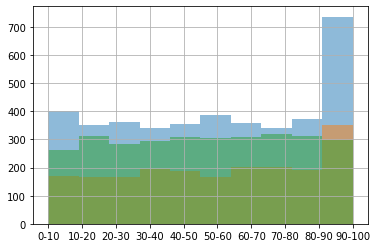

In [37]:
for df in [train_df, val_df, test_df]:
    df.sort_values(by=['age'])['age'].hist(alpha=0.5)

## Modeling
We are going to use a very naive approach here.

We will be reducing the number of pixels, take them out in a list, and then use a random forest classifier model.

In [39]:
def preprocessor(image_path, dataframe):
  # Go through each test image
  imgdatas = []
  for i in tqdm(range(dataframe.shape[0]), total = len(dataframe)):
    # Reading the test image
    imgdata = Image.open(os.path.join(image_path, dataframe['ImageID'][i]+'.jpg'))

    #Convert to grayscale
    imgdata = imgdata.convert('L')

    #Reshapes the image to a fix sahpe -> 190×190(You can choose any shape)
    imgdata = imgdata.resize((190,190))
    imgdata =np.asarray(imgdata)

    #Squeezes the matrix for feeding the value to model
    imgdata = np.squeeze(imgdata[10,:])

    imgdatas.append(imgdata)
  # image_ids.append(test_imgs[i].split(".")[0])
  dataframe['imgData'] = imgdatas
  return dataframe

In [40]:
base_path = 'data'
preprocessor(os.path.join(base_path,'train'), train_df)
preprocessor(os.path.join(base_path,'test'), test_df)
preprocessor(os.path.join(base_path,'val'), val_df)

100%|██████████| 2000/2000 [00:15<00:00, 125.32it/s]


,ImageID,age,imgData
0,444vl,40-50,"[60, 56, 55, 53, 52, 53, 52, 53, 52, 51, 50, 5..."
1,4eg4u,80-90,"[77, 77, 76, 76, 75, 74, 75, 76, 74, 74, 73, 7..."
2,8pk8y,40-50,"[125, 123, 124, 125, 124, 125, 126, 127, 128, ..."
3,qow33,90-100,"[76, 76, 77, 78, 78, 79, 81, 83, 83, 84, 85, 8..."
4,7ittd,20-30,"[77, 76, 75, 73, 72, 72, 71, 70, 69, 67, 66, 6..."
...,...,...,...
1995,0od5t,0-10,"[106, 105, 104, 101, 99, 98, 97, 96, 93, 92, 9..."
1996,do352,80-90,"[74, 72, 68, 67, 65, 65, 64, 64, 65, 66, 68, 7..."
1997,m58bc,90-100,"[157, 158, 160, 163, 165, 166, 170, 172, 174, ..."
1998,6xxax,50-60,"[118, 114, 111, 109, 107, 105, 103, 101, 100, ..."


In [41]:
train_df['imgData'][12].shape

(190,)

In [48]:
train_x = train_df.imgData
train_y = train_df.age

age_predictor = RandomForestClassifier(max_features=0.15, random_state=2)
age_predictor.fit(list(train_x),train_y)

RandomForestClassifier(max_features=0.15, random_state=2)

In [49]:
val_x = val_df.imgData
val_y = val_df.age

val_predict = age_predictor.predict(list(val_x))
print(f1_score(val_predict,val_y,average='weighted'))

0.21341366743272625


## Generating Prediction File
Now that we have created the baseline prediction, lets submit it.

In [50]:
test_x = test_df.imgData
test_predict = age_predictor.predict(list(test_x))

In [52]:
submission = pd.read_csv('data/sample_submission.csv')
submission['age'] = test_predict

In [53]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))